<a href="https://colab.research.google.com/github/chirucodes/aiml/blob/main/ImageCaptioningGroup4_BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reference Link

In [1]:
# Reference (GitHub):- https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb

### Download dataset and **unzip**

In [ ]:
!rm -rf Flickr8k_Dataset.zip
!rm -rf Flickr8k_text.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -O Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -O Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip

### Import Modules

In [3]:

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import optimizers
from keras import Input, layers
from keras.applications.inception_v3 import preprocess_input
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


In [4]:
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop


### Load Files and Contentsinto the workspace

In [5]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [6]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping


#### Trace - 1

In [7]:
#image_id
doc.split('\n')[0].split()[0].split('.')[0]

'1000268201_693b08cb0e'

In [8]:
#image_desc
' '.join(doc.split('\n')[0].split()[1:])

'A child in a pink dress is climbing up a set of stairs in an entry way .'

In [9]:
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [10]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [11]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
table = str.maketrans('', '', string.punctuation)

In [13]:
descriptions['10815824_2997e03d76'][2].split()

['A',
 'girl',
 'holding',
 'a',
 'horse',
 "'s",
 'lead',
 'behind',
 'a',
 'fire',
 '.']

In [14]:
desc = [w.translate(table) for w in descriptions['10815824_2997e03d76'][2].split()]

In [15]:
desc

['A', 'girl', 'holding', 'a', 'horse', 's', 'lead', 'behind', 'a', 'fire', '']

### Clean up the input data


In [16]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [17]:
descriptions['10815824_2997e03d76'][2]


'girl holding horse lead behind fire'

In [18]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [19]:
type(descriptions), list(descriptions.keys())[:5]

(dict,
 ['1000268201_693b08cb0e',
  '1001773457_577c3a7d70',
  '1002674143_1b742ab4b8',
  '1003163366_44323f5815',
  '1007129816_e794419615'])

In [20]:
"""
1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse
1000268201_693b08cb0e little girl climbing the stairs to her playhouse
1000268201_693b08cb0e little girl in pink dress going into wooden cabin
1001773457_577c3a7d70 black dog and spotted dog are fighting
"""

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')


### Train and Test sets



In [21]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [22]:
list(train)[:10]

['3576312396_799c873f3e',
 '235074044_c1358888ed',
 '3521201948_9049197f20',
 '3409740108_1505489537',
 '2328616978_fb21be2b87',
 '3215117062_6e07a86352',
 '3154693053_cfcd05c226',
 '2917843040_7c9caaaa8a',
 '279550225_d64d56158a',
 '3434452829_62cee280bc']

In [23]:
# Below path contains all the images
images = '/content/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [24]:
type(img), img[:5]

(list,
 ['/content/Flicker8k_Dataset/3079341641_f65f6b0f8b.jpg',
  '/content/Flicker8k_Dataset/489773343_a8aecf7db3.jpg',
  '/content/Flicker8k_Dataset/2428959030_bdffc2812e.jpg',
  '/content/Flicker8k_Dataset/2230067846_74046b89d3.jpg',
  '/content/Flicker8k_Dataset/241346471_c756a8f139.jpg'])

In [25]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))


In [26]:
list(train_images)[:5]

['2975807155_5a8610c297.jpg',
 '2735979477_eef7c680f9.jpg',
 '3588417747_b152a51c52.jpg',
 '495033548_bd320405d8.jpg',
 '1067675215_7336a694d6.jpg']

In [27]:
#i[len(images):] in train_images
# train_images
images, len(images), img[0][len(images):]
# img[0][]

('/content/Flicker8k_Dataset/', 27, '3079341641_f65f6b0f8b.jpg')

In [28]:

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [29]:
len(train_img), train_img[:5]

(6000,
 ['/content/Flicker8k_Dataset/3079341641_f65f6b0f8b.jpg',
  '/content/Flicker8k_Dataset/489773343_a8aecf7db3.jpg',
  '/content/Flicker8k_Dataset/2428959030_bdffc2812e.jpg',
  '/content/Flicker8k_Dataset/2230067846_74046b89d3.jpg',
  '/content/Flicker8k_Dataset/241346471_c756a8f139.jpg'])

In [30]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [31]:
len(test_img), test_img[:5]

(1000,
 ['/content/Flicker8k_Dataset/3364026240_645d533fda.jpg',
  '/content/Flicker8k_Dataset/1659358141_0433c9bf99.jpg',
  '/content/Flicker8k_Dataset/2311690895_0d6efe11c8.jpg',
  '/content/Flicker8k_Dataset/1982852140_56425fa7a2.jpg',
  '/content/Flicker8k_Dataset/2333288869_8c01e4c859.jpg'])

### Required dataset

In [32]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [33]:
list(train_descriptions.keys())[:5], train_descriptions['1000268201_693b08cb0e']

(['1000268201_693b08cb0e',
  '1001773457_577c3a7d70',
  '1002674143_1b742ab4b8',
  '1003163366_44323f5815',
  '1007129816_e794419615'],
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

In [34]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

#### Trace - 2

In [35]:
preprocess(train_img[0])

array([[[[ 0.69411767,  0.52156866, -0.27843136],
         [ 0.6784314 ,  0.54509807, -0.27058822],
         [ 0.69411767,  0.54509807, -0.26274508],
         ...,
         [-0.12941176, -0.8509804 , -0.9372549 ],
         [ 0.36470592, -0.35686272, -0.5529412 ],
         [ 0.4431373 , -0.26274508, -0.5529412 ]],

        [[ 0.70980394,  0.54509807, -0.27843136],
         [ 0.6862745 ,  0.5529412 , -0.26274508],
         [ 0.6862745 ,  0.5372549 , -0.27058822],
         ...,
         [-0.1372549 , -0.85882354, -0.9764706 ],
         [ 0.35686278, -0.35686272, -0.5686275 ],
         [ 0.28627455, -0.41960782, -0.69411767]],

        [[ 0.69411767,  0.5294118 , -0.29411763],
         [ 0.69411767,  0.54509807, -0.27843136],
         [ 0.69411767,  0.54509807, -0.26274508],
         ...,
         [-0.0745098 , -0.7882353 , -0.9372549 ],
         [ 0.39607847, -0.31764704, -0.54509807],
         [ 0.52156866, -0.18431371, -0.4588235 ]],

        ...,

        [[ 0.6627451 ,  0.8509804 ,  0

In [36]:
image_path_tmp = train_img[0]

In [37]:
# Convert all the images to size 299x299 as expected by the inception v3 model
img_tmp = image.load_img(image_path_tmp) #, target_size=(299, 299))

In [38]:
img_tmp.size

(333, 500)

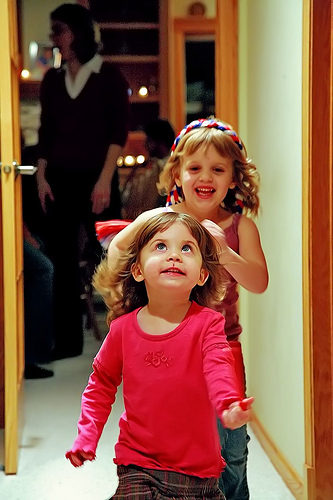

In [39]:
img_tmp

In [40]:
img_tmp = image.load_img(image_path_tmp, target_size=(299, 299))

In [41]:
img_tmp.size

(299, 299)

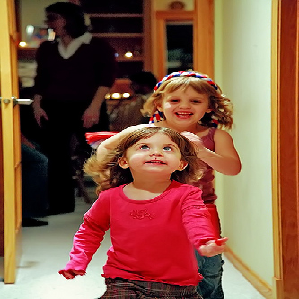

In [42]:
img_tmp

In [43]:
# Convert PIL image to numpy array of 3-dimensions
x_tmp = image.img_to_array(img_tmp)

In [44]:
x_tmp.shape

(299, 299, 3)

In [45]:
x_tmp2 = np.expand_dims(x_tmp, axis=0)

In [46]:
x_tmp2[0][0][0]

array([216., 194.,  92.], dtype=float32)

In [47]:
x_tmp2.shape

(1, 299, 299, 3)

In [48]:
x_tmp2[0].shape, x_tmp2[0][0].shape, x_tmp2[0][0][0].shape, x_tmp2[0][0][0], x_tmp[0][0][0]

((299, 299, 3),
 (299, 3),
 (3,),
 array([216., 194.,  92.], dtype=float32),
 216.0)

## Standardization and Normalization

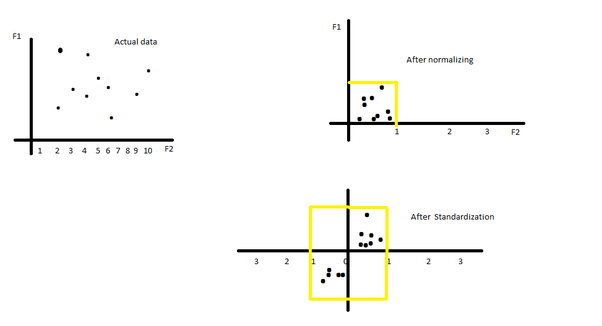

In [49]:
# from keras.applications.inception_v3 import preprocess_input
# For applying the scaling technique

x_tmp3 = preprocess_input(x_tmp2)

In [50]:
x_tmp3.shape

(1, 299, 299, 3)

In [51]:
x_tmp3[0][0][0]

array([ 0.69411767,  0.52156866, -0.27843136], dtype=float32)

### Model InceptionV3 initialization 
### Creating a new *model*

In [52]:
# Load the inception v3 model
# weights: One of None (random initialization), 
# imagenet (pre-training on ImageNet), or the path to the weights file to be loaded. 

#Default to imagenet.
#from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 2s 0us/step


#### Trace - 3

In [53]:
model, '   '.join(dir(model)[200:250])

(<keras.engine.functional.Functional at 0x7f05ac0c9490>,
 '_thread_local   _track_trackable   _trackable_children   _trackable_saved_model_saver   _trackable_saver   _tracking_metadata   _train_counter   _trainable   _trainable_weights   _training_state   _unconditional_checkpoint_dependencies   _unconditional_dependency_names   _undeduplicated_weights   _update_uid   _updated_config   _updates   _use_input_spec_as_call_signature   _validate_compile   _validate_graph_inputs_and_outputs   _validate_target_and_loss   activity_regularizer   add_loss   add_metric   add_update   add_variable   add_weight   apply   build   built   call   compile   compiled_loss   compiled_metrics   compute_dtype   compute_loss   compute_mask   compute_metrics   compute_output_shape   compute_output_signature   count_params   distribute_strategy   dtype   dtype_policy   dynamic   evaluate   evaluate_generator   finalize_state   fit   fit_generator   from_config')

In [54]:
model.input

<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'input_1')>

In [55]:
model.output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [56]:
model.layers[-1], model.layers[-2].output

(<keras.layers.core.dense.Dense at 0x7f05ac0c9790>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>)

In [57]:
type(model.layers), len(model.layers)

(list, 313)

In [58]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [59]:
model.layers[3].name, model.layers[4].name, model.layers[5].name, model.layers[6].name

('activation', 'conv2d_1', 'batch_normalization_1', 'activation_1')

In [60]:
# from keras.models import Model
Model

keras.engine.training.Model

In [61]:
model.layers[-2], model.layers[-2].output

(<keras.layers.pooling.GlobalAveragePooling2D at 0x7f05ac146250>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>)

In [62]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

#What is the output of the model here

In [63]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [64]:
len(model_new.layers)

312

### Convert the train and test images to a feature vector and store it in a pickle file

In [65]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

#### Trace - 4

In [66]:
# Trace encode()
image_tmp = preprocess(train_img[0])
image_tmp.shape

(1, 299, 299, 3)

In [67]:
fea_vec_tmp = model_new.predict(image_tmp)
fea_vec_tmp.shape, fea_vec_tmp

((1, 2048),
 array([[0.9209477 , 0.56833464, 0.94213027, ..., 0.4010797 , 1.7199961 ,
         0.12714769]], dtype=float32))

In [68]:
fea_vec_tmp1 = np.reshape(fea_vec_tmp, fea_vec_tmp.shape[1])

In [69]:
fea_vec_tmp1.shape, fea_vec_tmp1

((2048,),
 array([0.9209477 , 0.56833464, 0.94213027, ..., 0.4010797 , 1.7199961 ,
        0.12714769], dtype=float32))

In [70]:
time()

1656914270.107938

### .

In [71]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 348.9380204677582


In [72]:
type(encoding_train), list(encoding_train.keys())[:5]

(dict,
 ['3079341641_f65f6b0f8b.jpg',
  '489773343_a8aecf7db3.jpg',
  '2428959030_bdffc2812e.jpg',
  '2230067846_74046b89d3.jpg',
  '241346471_c756a8f139.jpg'])

In [73]:
encoding_train['3079341641_f65f6b0f8b.jpg'].shape

(2048,)

In [74]:
!mkdir "/content/sample_data/Pickle"

In [75]:
pkl_train_file="/content/sample_data/Pickle/encoded_train_images.pkl"

In [76]:
# Save the bottleneck train features to disk
with open(pkl_train_file, "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

    # /content/sample_data/Pickle/encoded_train_images.pkl

In [77]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 60.20816373825073


In [78]:
pkl_test_file = "/content/sample_data/Pickle/encoded_test_images.pkl"

In [79]:

# Save the bottleneck test features to disk
with open(pkl_test_file, "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [80]:
train_features = load(open(pkl_train_file, "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


### Load all the captions and prepare 
1.   word_dict
2.   ixtoword
3.   wordtoix

In [81]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [82]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [83]:
#To Check if there are any duplicate captions in train description. there are 232 duplicate entries
type(all_train_captions), len(all_train_captions), len(set(all_train_captions)), len(all_train_captions) - len(set(all_train_captions)) 

(list, 30000, 29768, 232)

In [84]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [85]:
type(word_counts), len(word_counts), list(word_counts.keys())[:10], list(word_counts.values())[:10]

(dict,
 7578,
 ['startseq',
  'child',
  'in',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'set',
  'of'],
 [30000, 1120, 14085, 543, 260, 6907, 375, 903, 81, 4967])

In [86]:
word_counts


{'startseq': 30000,
 'child': 1120,
 'in': 14085,
 'pink': 543,
 'dress': 260,
 'is': 6907,
 'climbing': 375,
 'up': 903,
 'set': 81,
 'of': 4967,
 'stairs': 81,
 'an': 1807,
 'entry': 1,
 'way': 41,
 'endseq': 30000,
 'girl': 2414,
 'going': 111,
 'into': 757,
 'wooden': 209,
 'building': 373,
 'little': 1266,
 'playhouse': 6,
 'the': 13509,
 'to': 2303,
 'her': 861,
 'cabin': 3,
 'black': 2854,
 'dog': 6159,
 'and': 6672,
 'spotted': 27,
 'are': 2619,
 'fighting': 97,
 'tricolored': 10,
 'playing': 1486,
 'with': 5763,
 'each': 318,
 'other': 567,
 'on': 8006,
 'road': 305,
 'white': 2921,
 'brown': 1995,
 'spots': 22,
 'staring': 43,
 'at': 2101,
 'street': 703,
 'two': 4246,
 'dogs': 1620,
 'different': 28,
 'breeds': 5,
 'looking': 563,
 'pavement': 39,
 'moving': 27,
 'toward': 109,
 'covered': 229,
 'paint': 44,
 'sits': 437,
 'front': 996,
 'painted': 50,
 'rainbow': 18,
 'hands': 180,
 'bowl': 21,
 'sitting': 1018,
 'large': 894,
 'small': 940,
 'grass': 1222,
 'plays': 392,
 

In [87]:

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [88]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [89]:
list(wordtoix.items())[:5], list(ixtoword.items())[:5]

([('startseq', 1), ('child', 2), ('in', 3), ('pink', 4), ('dress', 5)],
 [(1, 'startseq'), (2, 'child'), (3, 'in'), (4, 'pink'), (5, 'dress')])

In [90]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [91]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### DataLoader with batches

In [92]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Download Glove data set and load the content
GloVe - is an unsupervised learning algorithm for obtaining vector representations for words.



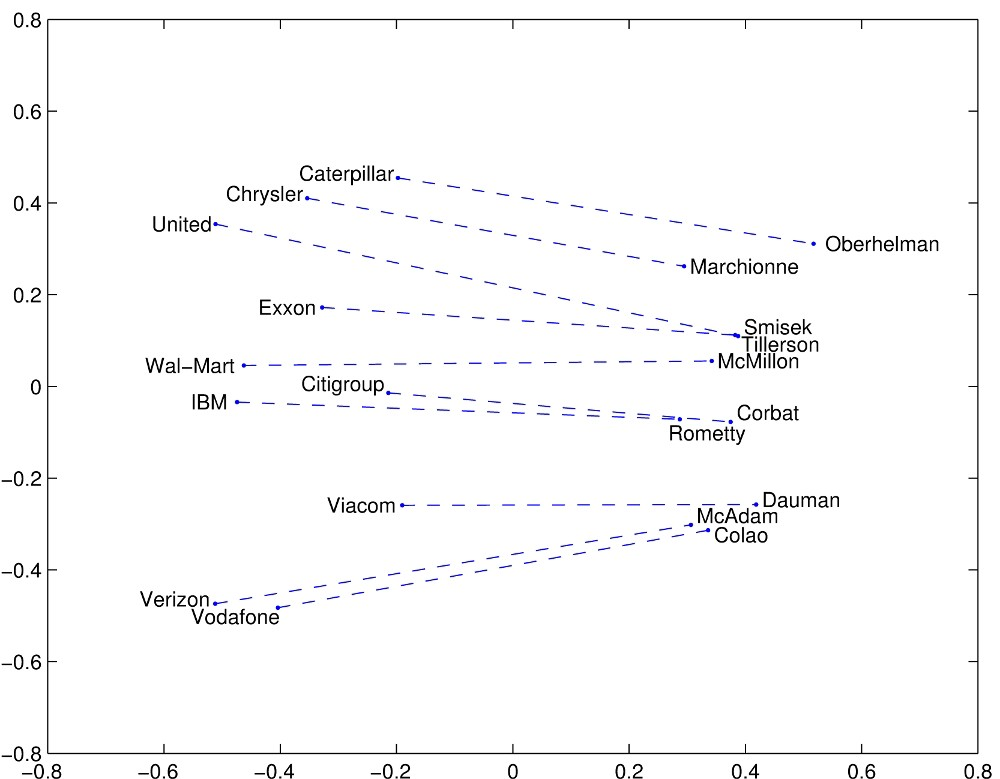

In [93]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-07-04 06:04:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-04 06:04:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-04 06:04:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [94]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [95]:
!wget http://nlp.stanford.edu/data/glove.6B.200d.zip

--2022-07-04 06:07:41--  http://nlp.stanford.edu/data/glove.6B.200d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.200d.zip [following]
--2022-07-04 06:07:41--  https://nlp.stanford.edu/data/glove.6B.200d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.200d.zip [following]
--2022-07-04 06:07:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.200d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-04 06:07:42 ERROR 404: Not Found.


In [96]:

# Load Glove vectors
glove_dir = '/content/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [97]:
type(embeddings_index), embeddings_index['feel'].shape, embeddings_index['feel'][:10]

(dict,
 (200,),
 array([ 0.28771 ,  0.064966, -0.20529 , -0.10327 , -0.075605, -0.13953 ,
        -0.31555 ,  0.20159 ,  0.2793  ,  0.51803 ], dtype=float32))

In [98]:
vocab_size

1652

In [99]:
embeddings_index

{'the': array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
         3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
         1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
        -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
         4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
         7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
         1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
        -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
        -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
         6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
        -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
         8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
         1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
         1.4379e-01, -1.2325e-01, -5.8178e-0

### Load the vectors for required words

In [100]:

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
missing_word_list = list()

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
    else:
        missing_word_list.append(word)

In [101]:
embedding_matrix_tmp = np.zeros((vocab_size, 10))
embedding_matrix_tmp.shape
embedding_matrix_tmp[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [102]:
embedding_matrix.shape

(1652, 200)

In [103]:
vocab_size

1652

In [104]:
missing_word_count=0
for each in embedding_matrix:
    if not all(each):
        # print(each)
        missing_word_count += 1

print("number of words missed: %s" % missing_word_count)


number of words missed: 10


### Create a LSTM kind model

In [105]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [106]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [107]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

### Training the model

In [108]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [109]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [120]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

   1/2000 [..............................] - ETA: 2:44 - loss: 2.5912

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 164s 82ms/step - loss: 2.3899


In [111]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

   1/2000 [..............................] - ETA: 3:15 - loss: 2.9039

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 165s 82ms/step - loss: 2.5362


In [ ]:
model.optimizer.lr = 0.0001
epochs = 3
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [113]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

   1/2000 [..............................] - ETA: 2:36 - loss: 2.7015

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 165s 83ms/step - loss: 2.4207


### Saving and loading the model weights

In [ ]:

model.save_weights('./model_weights/model_30.h5')

In [ ]:
model.load_weights('./model_weights/model_30.h5')

In [116]:
images = '/content/Flicker8k_Dataset/'

In [117]:
with open(pkl_test_file, "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

### Model Testing

In [118]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

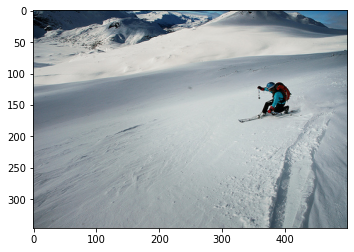

Greedy: skier in red jacket and white jacket is skiing down snowy hill


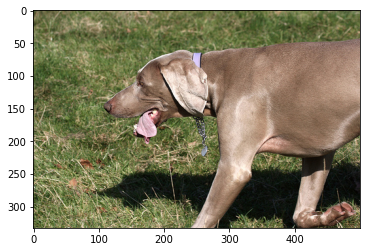

Greedy: brown dog is running through the grass


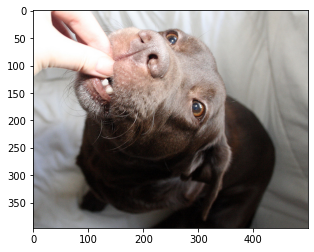

Greedy: brown dog is laying on its back with its mouth open


In [119]:
for z in range(3):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))